# **Speaker Identification System using MFCC**

## Installing and Importing Necessary Libraries and Modules


*   Installing all the necessary librarires required for the project



In [ ]:
# Installing all necessary libraries
!pip install librosa
!pip install pydub
!pip install flask
!pip install pyngrok
!pip install flask pyngrok librosa numpy pandas joblib scikit-learn

*   Importing all the necessary modules required for the project


In [ ]:
# Importing necessary modules
import os
import librosa
import numpy as np
import pandas as pd
from pydub import AudioSegment
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from flask import Flask, request, render_template_string
from pyngrok import ngrok
from werkzeug.utils import secure_filename
import nest_asyncio


## Data Processing and Computing MFCC features


*   The dataset is taken from Audio minist datset (Github)
*   The dataset is unzipped and contents are extracted.




In [ ]:
# Unzipping and extracting the contents of dataset file.

!unzip /content/archive.zip -d /content/extracted_archive

Archive:  /content/archive.zip
  inflating: /content/extracted_archive/free-spoken-digit-dataset-master/.gitignore  
  inflating: /content/extracted_archive/free-spoken-digit-dataset-master/README.md  
  inflating: /content/extracted_archive/free-spoken-digit-dataset-master/__init__.py  
  inflating: /content/extracted_archive/free-spoken-digit-dataset-master/acquire_data/say_numbers_prompt.py  
  inflating: /content/extracted_archive/free-spoken-digit-dataset-master/acquire_data/split_and_label_numbers.py  
  inflating: /content/extracted_archive/free-spoken-digit-dataset-master/metadata.py  
  inflating: /content/extracted_archive/free-spoken-digit-dataset-master/pip_requirements.txt  
  inflating: /content/extracted_archive/free-spoken-digit-dataset-master/recordings/0_george_0.wav  
  inflating: /content/extracted_archive/free-spoken-digit-dataset-master/recordings/0_george_1.wav  
  inflating: /content/extracted_archive/free-spoken-digit-dataset-master/recordings/0_george_10.wav  



* Converts `.m4a` to `.wav` for consistency.  
* Extracts MFCC features (with deltas) from audio files.  
* Combines speaker metadata with features.  
* Saves the processed data to a CSV file.  


In [ ]:
# Function to Convert m4a files to .wav format
def convert_to_wav(input_path, output_path):
    try:
        audio = AudioSegment.from_file(input_path, format="m4a")
        audio.export(output_path, format="wav")
        return output_path
    except Exception as e:
        print(f"Error converting audio: {e}")
        return None

# Function to compute mfcc features
def calculate_mfcc(file_path, n_mfcc=13, delta_width=3):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None) # Loading the audio file
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc) # Computing MFCC features

        if mfcc.shape[1] < delta_width: # Ensuring the number of frames is sufficient for delta computation
            print(f"Skipping {file_path}: Too few frames ({mfcc.shape[1]} < {delta_width})")
            return None

        delta_mfcc = librosa.feature.delta(mfcc, width=delta_width) # Computing first derivative of MFCCs
        delta2_mfcc = librosa.feature.delta(mfcc, order=2, width=delta_width) # Computing second derivative of MFCCs
        # Concatenating all features: MFCC + first derivative + second derivative
        combined_mfcc = np.hstack((np.mean(mfcc, axis=1),np.mean(delta_mfcc, axis=1),np.mean(delta2_mfcc, axis=1)))
        return combined_mfcc

    except Exception as e:
        print(f"Error calculating MFCCs for {file_path}: {e}")
        return None

# Function for Preprocesssing Audio files
def preprocess_audio_files(input_dir, output_csv, n_mfcc=13, delta_width=3):
    data = []  # Initializing a list to store all processed data

    for file_name in os.listdir(input_dir): # Iterating over all audio files in the input directory
        if file_name.endswith(('.wav', '.m4a')):
            try: # Extract speaker name from the filename (e.g., '0_yweweler_39.wav' -> 'yweweler')
                speaker_name = file_name.split('_')[1]
            except IndexError:
                print(f"Invalid file format: {file_name}")
                continue
            if speaker_name in metadata: # Matching the speaker's metadata
                speaker_meta = metadata[speaker_name]
            else:
                print(f"Speaker {speaker_name} not found in metadata. Skipping...")
                continue
            file_path = os.path.join(input_dir, file_name)  # Full path to the audio file

            if file_name.endswith('.m4a'): # Converting m4a to wav
                converted_path = file_path.replace('.m4a', '.wav')
                file_path = convert_to_wav(file_path, converted_path)
                if not file_path:
                    continue

            mfcc_features = calculate_mfcc(file_path, n_mfcc=n_mfcc, delta_width=delta_width)  # Extracting MFCC features
            if mfcc_features is None:
                continue
            # Combining metadata and features
            record = {'speaker': speaker_name,'gender': speaker_meta['gender'],'accent': speaker_meta['accent'],'language': speaker_meta['language']}
            for i, coeff in enumerate(mfcc_features): # Adding MFCC features as individual columns
                record[f'mfcc_{i+1}'] = coeff
            data.append(record) # Appending to the data list

    # Creating a DataFrame and saving it as a CSV
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"Processed data saved to {output_csv}")


* Defines speaker metadata and file paths.  
* Extracts MFCC features and save to CSV.  
* Computes and visualizes MFCC feature correlations.

Processed data saved to processed_speaker_data.csv


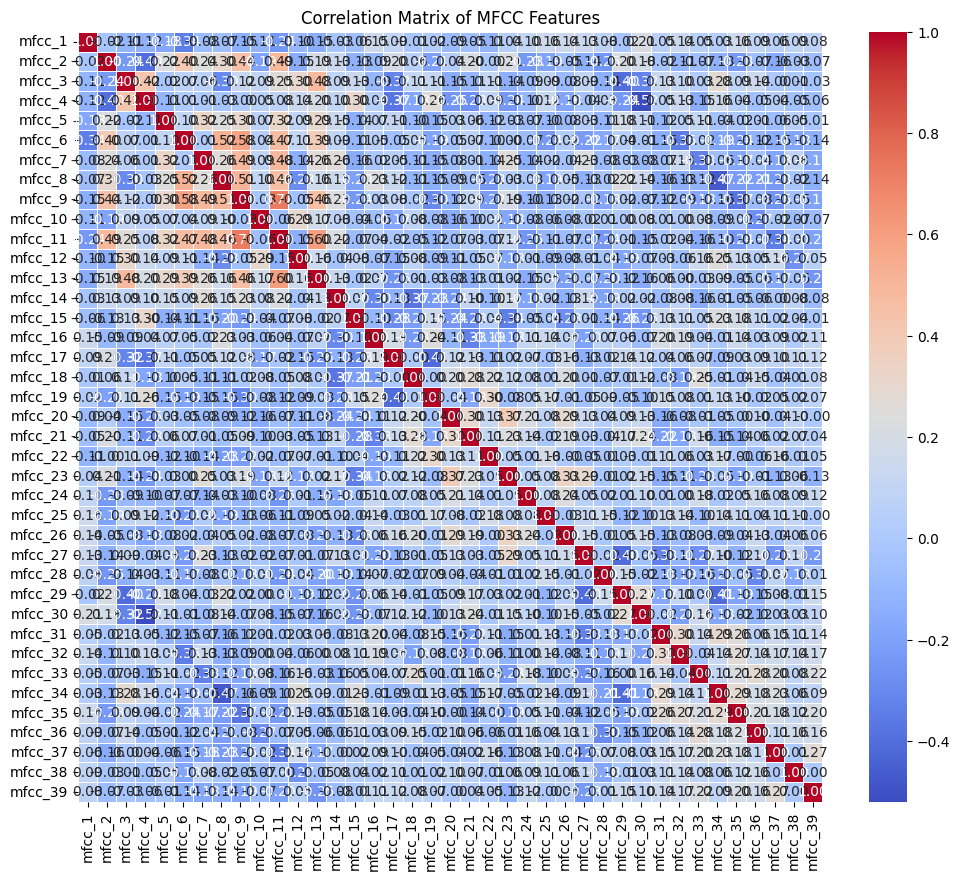

In [ ]:
# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Metadata about the speakers
metadata = {'jackson': {'gender': 'male', 'accent': 'USA/neutral', 'language': 'english'},
    'nicolas': {'gender': 'male', 'accent': 'BEL/French', 'language': 'english'},
    'theo': {'gender': 'male', 'accent': 'USA/neutral', 'language': 'english'},
    'yweweler': {'gender': 'male', 'accent': 'DEU/German', 'language': 'english'},
    'george': {'gender': 'male', 'accent': 'GRC/Greek', 'language': 'english'},
    'lucas': {'gender': 'male', 'accent': 'DEU/German', 'language': 'english'}}

# Defining  paths
INPUT_DIR = "/content/extracted_archive/free-spoken-digit-dataset-master/recordings"  # Replace with the actual path to your audio files
OUTPUT_CSV = r"processed_speaker_data.csv"  # Path to save the processed data

# Run preprocessing
preprocess_audio_files(INPUT_DIR, OUTPUT_CSV)

# Path to the processed data
PROCESSED_CSV = "/content/processed_speaker_data.csv"  # Replace with the actual file path

# Loading the processed CSV file
df = pd.read_csv(PROCESSED_CSV)

# Selecting only numerical columns (MFCC features)
mfcc_columns = [col for col in df.columns if col.startswith('mfcc_')]
df_mfcc = df[mfcc_columns]

# Computing the correlation matrix
correlation_matrix = df_mfcc.corr()

# Displaying the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of MFCC Features')
plt.show()


## Training the Model

* Loads the speaker dataset.  
* Maps categorical features (gender, accent, language) to numeric values.  
* Adds new encoded columns and drop the original categorical ones.  
* Verify changes by displaying the updated dataset.  

In [ ]:
# Loading the dataframe.
df = pd.read_csv('processed_speaker_data.csv')

# Defining the mapping for categorical features.
gender_mapping = {'male': 1, 'female': 0}
accent_mapping = {'USA/neutral': 1, 'BEL/French': 2, 'DEU/German': 3, 'GRC/Greek': 4}
language_mapping = {'english': 1}

# Applying the mapping and create new columns
df['gender_encoded'] = df['gender'].map(gender_mapping)
df['accent_encoded'] = df['accent'].map(accent_mapping)
df['language_encoded'] = df['language'].map(language_mapping)

# Dropping the original categorical columns if needed.
df = df.drop(columns=['gender', 'accent', 'language'])

# Print the modified DataFrame to verify changes.
print(df.head())

    speaker     mfcc_1     mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0     lucas -384.26880  17.323730  14.390305  26.673082 -31.609581   7.133003   
1      theo -439.32420  27.778316  31.199360   9.723121  -0.998183 -18.031250   
2    george -245.57008  21.402775 -37.737940  -8.660471 -57.233932 -28.788961   
3     lucas -219.32452  45.066563  18.562094  29.505032 -54.155200   1.701038   
4  yweweler -293.97040  23.971458  34.605680   2.329066 -58.193184  -5.008383   

      mfcc_7     mfcc_8     mfcc_9  ...   mfcc_33   mfcc_34   mfcc_35  \
0 -23.658817  12.851891  -3.623103  ... -1.533186  0.779625 -0.146487   
1 -12.060319 -27.962488  -7.977602  ...  4.118837  2.509623  1.937866   
2 -32.558290  -7.712480 -28.136120  ...  5.028841 -1.493118  1.966510   
3 -21.893663 -10.617831 -13.853312  ... -0.375082 -3.778408  1.420969   
4 -34.778170 -17.172152 -17.532764  ...  5.236890  2.580367  2.541273   

    mfcc_36   mfcc_37   mfcc_38   mfcc_39  gender_encoded  accent_encoded 

- Extracts MFCC features and their derivatives from audio files.  
- Includes functionality to save and load the model, scaler, and label encoder using joblib.  
- Predicts the speaker of a new audio file by extracting, scaling features, and using the trained model.  

In [ ]:
# Function to extract MFCC features from a new audio file
def extract_mfcc_features(file_path, n_mfcc=13, delta_width=3):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None) # Loading the audio file
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)  # Computing MFCC features

        if mfcc.shape[1] < delta_width: # Ensuring the number of frames is sufficient for delta computation
            print(f"Skipping {file_path}: Too few frames ({mfcc.shape[1]} < {delta_width})")
            return None

        delta_mfcc = librosa.feature.delta(mfcc, width=delta_width) # Computing first derivative of MFCCs
        delta2_mfcc = librosa.feature.delta(mfcc, order=2, width=delta_width) # Computing second derivative of MFCCs
        # Concatenate all features: MFCC + first derivative + second derivative
        combined_mfcc = np.hstack((np.mean(mfcc, axis=1),np.mean(delta_mfcc, axis=1),np.mean(delta2_mfcc, axis=1)))
        return combined_mfcc

    except Exception as e:
        print(f"Error calculating MFCCs for {file_path}: {e}")
        return None

# Function to Save the model, scaler, and label encoder
def save_model(model, scaler, label_encoder, output_path='speaker_identification_model.joblib'):
    joblib.dump({'model': model,'scaler': scaler,'label_encoder': label_encoder}, output_path)
    print(f"Model saved to {output_path}")

# Function to Load the saved model
def load_model(model_path='speaker_identification_model.joblib'):
    saved_data = joblib.load(model_path)
    return saved_data['model'], saved_data['scaler'], saved_data['label_encoder']

# Function to Predict speaker for a new audio file
def predict_speaker(audio_file_path, model_path='speaker_identification_model.joblib'):
    model, scaler, label_encoder = load_model(model_path) # Loading the saved model, scaler, and label encoder
    features = extract_mfcc_features(audio_file_path) # Extracting MFCC features from the new audio file

    if features is None:
        print("Could not extract features from the audio file.")
        return None

    features_scaled = scaler.transform(features.reshape(1, -1))  # Standardizing the features

    # Predicting the speaker
    prediction = model.predict(features_scaled)
    predicted_speaker = label_encoder.inverse_transform(prediction)[0]

    return predicted_speaker

- Loads and processes the dataset to extract features and target.  
- Encodes the target variable (speaker) and splits the data into training and testing sets.  
- Standardizes features and trains a Gradient Boosting Classifier.  
- Evaluates the model using classification metrics and saves the trained model, scaler, and label encoder.

In [ ]:
# Loading the dataframe
df = pd.read_csv('/content/processed_speaker_data.csv')

# Defining the target and features
TARGET = "speaker"
FEATURES = [col for col in df.columns if col.startswith("mfcc_")]

# Extracting features and target
X = df[FEATURES]
y = df[TARGET]

# Encoding the target 'speaker' column
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initializing and training Gradient Boosting Classifier
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Evaluating the model
y_pred = model.predict(X_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test)

print("Classification Report:")
print(classification_report(y_test_decoded, y_pred_decoded))
print("Accuracy:", accuracy_score(y_test_decoded, y_pred_decoded))

# Saving the model, scaler, and label encoder
save_model(model, scaler, label_encoder)

print("Model saved and ready for prediction!")

## Integrating Web Application

- Initializes a Flask app for audio file upload and speaker identification.  
- Extracts MFCC features from uploaded audio files using librosa.
- Designs a user-friendly, responsive webpage using HTML, CSS and Flask.
- Loads a pre-trained model and predicts the speaker based on extracted features.  
- Displays the result or error message on the web interface with ngrok providing remote access.

In [ ]:
nest_asyncio.apply() # Applying nest_asyncio
app = Flask(__name__) # Initializing Flask app

# Configuring upload folder
UPLOAD_FOLDER = 'uploads'
ALLOWED_EXTENSIONS = {'wav', 'mp3', 'flac'}
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024  # 16MB max file size

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

# Function to extract MFCC features
def extract_mfcc_features(file_path, n_mfcc=13, delta_width=3):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

        if mfcc.shape[1] < delta_width:
            return None

        delta_mfcc = librosa.feature.delta(mfcc, width=delta_width)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2, width=delta_width)

        combined_mfcc = np.hstack((np.mean(mfcc, axis=1),
                                 np.mean(delta_mfcc, axis=1),
                                 np.mean(delta2_mfcc, axis=1)))
        return combined_mfcc
    except Exception as e:
        print(f"Error calculating MFCCs: {e}")
        return None

# HTML template
HTML_TEMPLATE = '''
<!DOCTYPE html>
<html>
<head>
    <title>Speaker Sync Squad | Speaker Identification System</title>
    <link href="https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;600&display=swap" rel="stylesheet">
    <style>
        * {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }
        body {
            font-family: 'Poppins', Arial, sans-serif;
            background: linear-gradient(135deg, #6a11cb 0%, #2575fc 100%);
            min-height: 100vh;
            display: flex;
            justify-content: center;
            align-items: center;
            padding: 20px;
        }
        .container {
            background: rgba(255, 255, 255, 0.9);
            border-radius: 20px;
            box-shadow: 0 15px 35px rgba(0, 0, 0, 0.1);
            width: 100%;
            max-width: 500px;
            padding: 40px;
            text-align: center;
            position: relative;
            overflow: hidden;
            transform: perspective(1000px) rotateX(-10deg) scale(1.05);
            transition: all 0.3s ease;
        }
        .container:hover {
            transform: perspective(1000px) rotateX(0deg) scale(1.02);
            box-shadow: 0 20px 40px rgba(0, 0, 0, 0.15);
        }
        .team-badge {
            position: absolute;
            top: 20px;
            right: 20px;
            background: linear-gradient(45deg, #6a11cb, #2575fc);
            color: white;
            padding: 8px 15px;
            border-radius: 20px;
            font-weight: 600;
            font-size: 14px;
            text-transform: uppercase;
            letter-spacing: 1px;
        }
        h1 {
            color: #2c3e50;
            margin-bottom: 30px;
            font-size: 28px;
            font-weight: 600;
            position: relative;
        }
        h1::after {
            content: '';
            position: absolute;
            width: 80px;
            height: 4px;
            background: linear-gradient(45deg, #6a11cb, #2575fc);
            bottom: -10px;
            left: 50%;
            transform: translateX(-50%);
            border-radius: 2px;
        }
        .upload-form {
            margin: 30px 0;
        }
        .file-input {
            display: none;
        }
        .file-label {
            display: inline-block;
            padding: 12px 25px;
            background: linear-gradient(45deg, #6a11cb, #2575fc);
            color: white;
            border-radius: 30px;
            cursor: pointer;
            transition: transform 0.3s ease;
            font-weight: 600;
        }
        .file-label:hover {
            transform: scale(1.05);
        }
        .submit-btn {
            display: inline-block;
            margin-top: 20px;
            padding: 12px 25px;
            background: #2ecc71;
            color: white;
            border: none;
            border-radius: 30px;
            cursor: pointer;
            transition: all 0.3s ease;
            font-weight: 600;
        }
        .submit-btn:hover {
            background: #27ae60;
            transform: translateY(-3px);
        }
        .selected-file {
            margin: 15px 0;
            color: #7f8c8d;
            font-size: 14px;
        }
        .result {
            margin-top: 20px;
            padding: 20px;
            border-radius: 10px;
            font-weight: 600;
        }
        .result.success {
            background: rgba(46, 204, 113, 0.1);
            color: #2ecc71;
        }
        .result.error {
            background: rgba(231, 76, 60, 0.1);
            color: #e74c3c;
        }
        footer {
            margin-top: 30px;
            font-size: 12px;
            color: #34495e;
            opacity: 0.7;
        }
        .team-members {
            font-size: 12px;
            color: #7f8c8d;
            margin-top: 10px;
        }
    </style>
</head>
<body>
    <div class="container">
        <div class="team-badge">Speaker Sync Squad</div>
        <h1>Speaker Identification System</h1>
        <div class="upload-form">
            <form method="post" enctype="multipart/form-data">
                <label for="file" class="file-label">Choose Audio File</label>
                <input type="file" id="file" name="file" class="file-input" accept=".wav,.mp3,.flac" onchange="updateFileName(this)">
                <div id="selectedFile" class="selected-file">No file selected</div>
                <input type="submit" value="Identify Speaker" class="submit-btn">
            </form>
        </div>
        {% if result %}
            <div class="result {% if error %}error{% else %}success{% endif %}">
                {{ result }}
            </div>
        {% endif %}
        <footer>
            Built with ❤️ for audio analysis
            <div class="team-members">
                Team Members: Arjun, Anish, Rishi, Rohith, Prem
            </div>
        </footer>
    </div>
    <script>
        function updateFileName(input) {
            const fileName = input.files[0]?.name || 'No file selected';
            document.getElementById('selectedFile').textContent = fileName;
        }
    </script>
</body>
</html>

'''

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    result = None
    error = False

    if request.method == 'POST':
        if 'file' not in request.files:
            result = 'No file uploaded'
            error = True
        else:
            file = request.files['file']
            if file.filename == '':
                result = 'No file selected'
                error = True
            elif not allowed_file(file.filename):
                result = 'Invalid file type. Please upload WAV, MP3, or FLAC files.'
                error = True
            else:
                try:
                    filename = secure_filename(file.filename)
                    filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
                    file.save(filepath)

                    # Loading the model and making prediction
                    model_data = joblib.load('speaker_identification_model.joblib')
                    model = model_data['model']
                    scaler = model_data['scaler']
                    label_encoder = model_data['label_encoder']

                    # Extracting features
                    features = extract_mfcc_features(filepath)
                    if features is not None:
                        features_scaled = scaler.transform(features.reshape(1, -1))
                        prediction = model.predict(features_scaled)
                        speaker = label_encoder.inverse_transform(prediction)[0]
                        result = f'Identified Speaker: {speaker}'
                    else:
                        result = 'Error processing audio file'
                        error = True

                    # Cleaning up uploaded file
                    os.remove(filepath)

                except Exception as e:
                    result = f'Error processing file: {str(e)}'
                    error = True

    return render_template_string(HTML_TEMPLATE, result=result, error=error)

# Setting up ngrok
ngrok.set_auth_token("2qX2Q4uVyB9UqyZHjsxfucdU2aR_3EwPJbvn3RyzBVpyMxKLN")
public_url = ngrok.connect(5000)
print(f' * Public URL: {public_url}')

# Running the app
app.run()